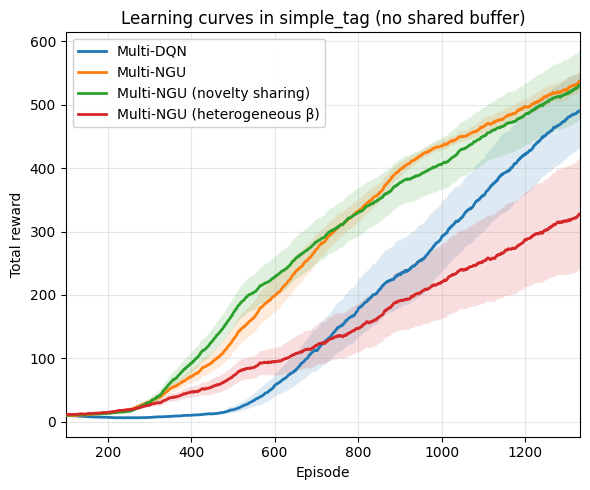

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

carpeta = "Shared"

configs = {
    "Multi-DQN": f"{carpeta}/multi_dqn",
    "Multi-NGU": f"{carpeta}/multi_ngu",
    "Multi-NGU (novelty sharing)": f"{carpeta}/multinovelty_any",
    "Multi-NGU (heterogeneous β)": f"{carpeta}/heterogeneous_beta"
}

agent   = "adversary_0"
n_runs  = 15
window  = 100

def rolling(x, w):
    return x.rolling(window=w, min_periods=w).mean()

plt.figure(figsize=(6, 5))

for idx, (config_name, folder) in enumerate(configs.items()):
    dfs = []
    for i in range(1, n_runs + 1):
        path = f"{folder}/run_{i}.csv"
        df = pd.read_csv(path, usecols=["episode", agent])
        dfs.append(df.rename(columns={agent: f"run_{i}"}))

    # Merge por episodio
    merged = dfs[0]
    for df in dfs[1:]:
        merged = merged.merge(df, on="episode", how="inner")

    run_cols = [c for c in merged.columns if c.startswith("run_")]

    # Suavizar cada run primero
    for c in run_cols:
        merged[c] = rolling(merged[c], window)

    # Media entre runs
    mean = merged[run_cols].mean(axis=1)

    # Banda según modo
    sem  = merged[run_cols].std(axis=1, ddof=1) / np.sqrt(len(run_cols))
    lo   = mean - 1.96 * sem
    hi   = mean + 1.96 * sem

    # Limitar a puntos válidos (tras el rolling)
    valid = ~mean.isna()
    x = merged.loc[valid, "episode"]
    y = mean.loc[valid]
    lo = lo.loc[valid]
    hi = hi.loc[valid]

    # Línea + banda (baja opacidad y zorder ordenado)
    plt.plot(x, y, label=config_name, linewidth=2, zorder=10+idx)
    plt.fill_between(x, lo, hi, alpha=0.15, linewidth=0, zorder=idx)

plt.xlim(x.min(), x.max())  # recorta márgenes del eje
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title(f"Learning curves in simple_tag (no shared buffer)")
plt.grid(True, alpha=0.3)
plt.legend(framealpha=0.9)
plt.tight_layout()
plt.show()


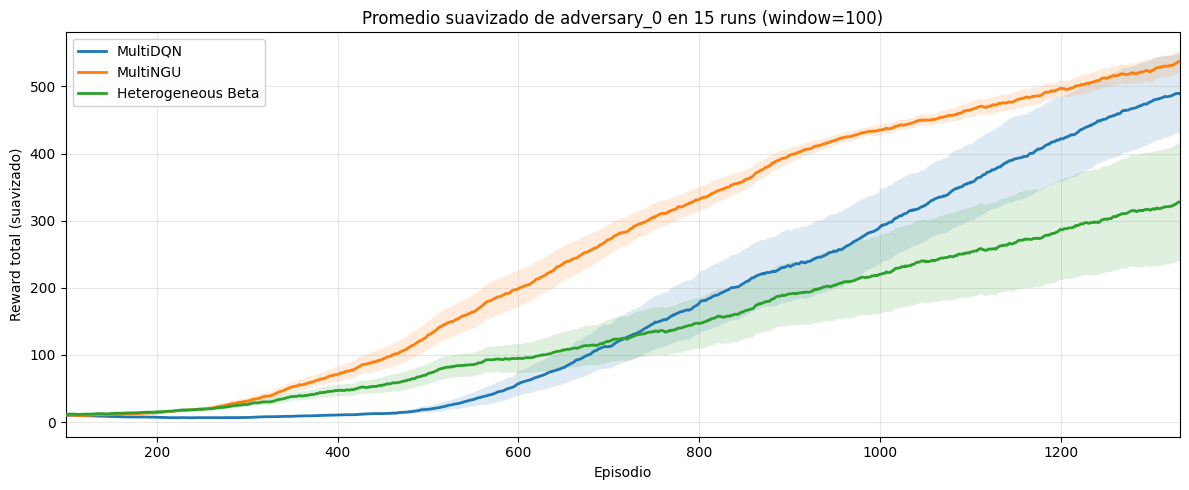

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

carpeta = "Shared"

configs = {
    "MultiDQN": f"{carpeta}/multi_dqn",
    "MultiNGU": f"{carpeta}/multi_ngu",
    #"MultiNovelty": f"{carpeta}/multinovelty_any",
    "Heterogeneous Beta": f"{carpeta}/heterogeneous_beta"
}

agent   = "adversary_0"
n_runs  = 15
window  = 100

def rolling(x, w):
    return x.rolling(window=w, min_periods=w).mean()

plt.figure(figsize=(12,5))

for idx, (config_name, folder) in enumerate(configs.items()):
    dfs = []
    for i in range(1, n_runs + 1):
        path = f"{folder}/run_{i}.csv"
        df = pd.read_csv(path, usecols=["episode", agent])
        dfs.append(df.rename(columns={agent: f"run_{i}"}))

    # Merge por episodio
    merged = dfs[0]
    for df in dfs[1:]:
        merged = merged.merge(df, on="episode", how="inner")

    run_cols = [c for c in merged.columns if c.startswith("run_")]

    # Suavizar cada run primero
    for c in run_cols:
        merged[c] = rolling(merged[c], window)

    # Media entre runs
    mean = merged[run_cols].mean(axis=1)

    # Banda según modo
    sem  = merged[run_cols].std(axis=1, ddof=1) / np.sqrt(len(run_cols))
    lo   = mean - 1.96 * sem
    hi   = mean + 1.96 * sem

    # Limitar a puntos válidos (tras el rolling)
    valid = ~mean.isna()
    x = merged.loc[valid, "episode"]
    y = mean.loc[valid]
    lo = lo.loc[valid]
    hi = hi.loc[valid]

    # Línea + banda (baja opacidad y zorder ordenado)
    plt.plot(x, y, label=config_name, linewidth=2, zorder=10+idx)
    plt.fill_between(x, lo, hi, alpha=0.15, linewidth=0, zorder=idx)

plt.xlim(x.min(), x.max())  # recorta márgenes del eje
plt.xlabel("Episodio")
plt.ylabel("Reward total (suavizado)")
plt.title(f"Promedio suavizado de {agent} en {n_runs} runs (window={window})")
plt.grid(True, alpha=0.3)
plt.legend(framealpha=0.9)
plt.tight_layout()
plt.show()


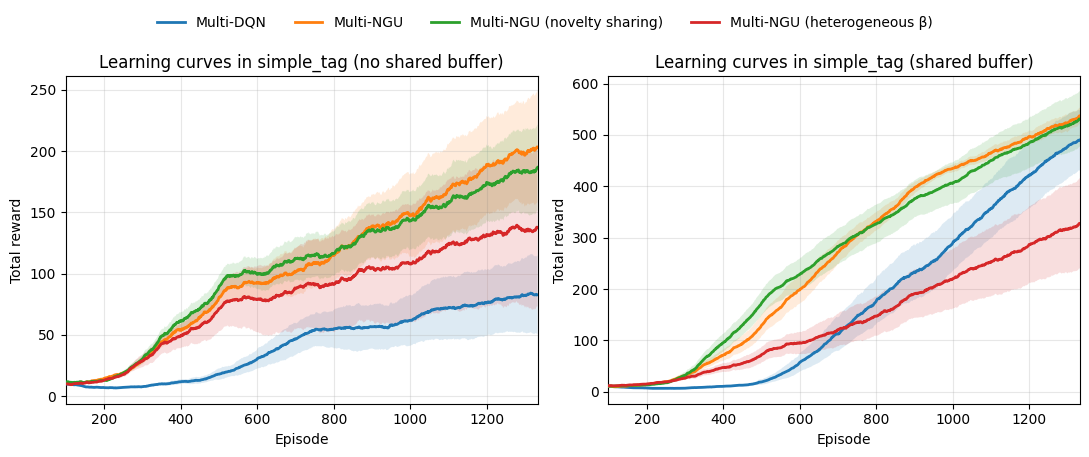

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce

agent   = "adversary_0"
n_runs  = 15
window  = 100

def rolling(x, w):
    return x.rolling(window=w, min_periods=w).mean()

def plot_panel(ax, carpeta, title):
    configs = {
        "Multi-DQN": f"{carpeta}/multi_dqn",
        "Multi-NGU": f"{carpeta}/multi_ngu",
        "Multi-NGU (novelty sharing)": f"{carpeta}/multinovelty_any",
        "Multi-NGU (heterogeneous β)": f"{carpeta}/heterogeneous_beta"
    }

    for idx, (config_name, folder) in enumerate(configs.items()):
        dfs = []
        for i in range(1, n_runs + 1):
            path = f"{folder}/run_{i}.csv"
            df = pd.read_csv(path, usecols=["episode", agent])
            dfs.append(df.rename(columns={agent: f"run_{i}"}))

        # Merge por episodio (inner = solo episodios comunes)
        merged = reduce(lambda a, b: a.merge(b, on="episode", how="inner"), dfs).sort_values("episode")
        run_cols = [c for c in merged.columns if c.startswith("run_")]

        # Suavizar cada run
        for c in run_cols:
            merged[c] = rolling(merged[c], window)

        # Agregar sobre seeds
        mean = merged[run_cols].mean(axis=1)
        sem  = merged[run_cols].std(axis=1, ddof=1) / np.sqrt(len(run_cols))
        lo   = mean - 1.96 * sem
        hi   = mean + 1.96 * sem

        # Puntos válidos post-rolling
        valid = ~mean.isna()
        x = merged.loc[valid, "episode"].to_numpy()
        y = mean.loc[valid].to_numpy()
        lo = lo.loc[valid].to_numpy()
        hi = hi.loc[valid].to_numpy()

        # Línea + banda
        ax.plot(x, y, label=config_name, linewidth=2, zorder=10+idx)
        ax.fill_between(x, lo, hi, alpha=0.15, linewidth=0, zorder=idx)

    ax.set_xlim(x.min(), x.max())
    ax.set_xlabel("Episode")
    ax.set_ylabel("Total reward")
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

# ===== Figura con dos paneles lado a lado =====
fig, axes = plt.subplots(1, 2, figsize=(11, 4.5), sharey=False)

# Izquierda: No_shared — Derecha: Shared
plot_panel(axes[0], "No_shared",  "Learning curves in simple_tag (no shared buffer)")
plot_panel(axes[1], "Shared",     "Learning curves in simple_tag (shared buffer)")

# Leyenda global arriba en una fila
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=len(labels), frameon=False, bbox_to_anchor=(0.5, 1.02))

# Ajuste para no pisar la leyenda
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

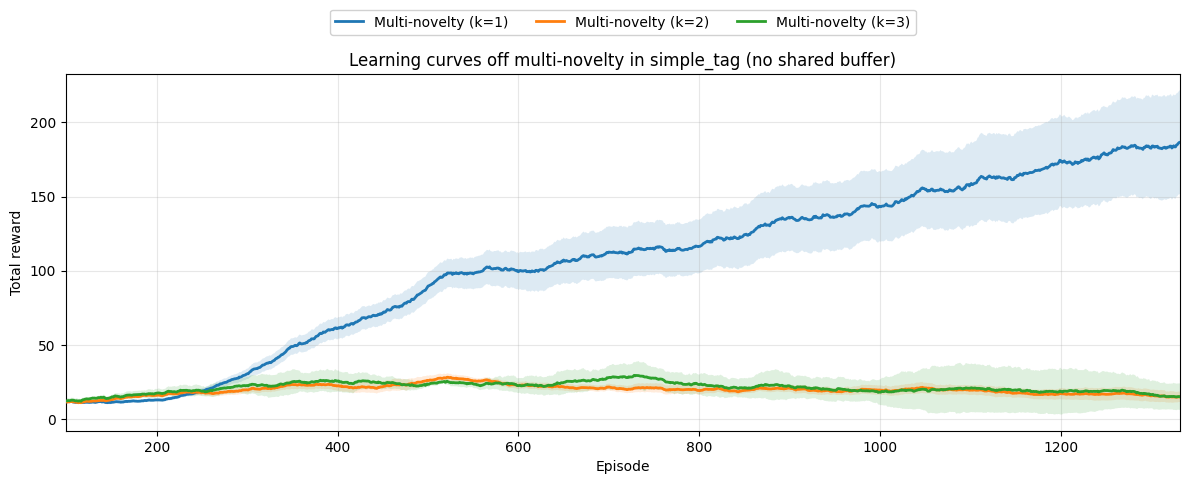

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

configs = {
    "Multi-novelty (k=1)": {"folder": "Appendix/multinovelty/k_1", "n_runs": 15},
    "Multi-novelty (k=2)": {"folder": "Appendix/multinovelty/k_2", "n_runs": 15},
    "Multi-novelty (k=3)": {"folder": "Appendix/multinovelty/k_3", "n_runs": 5},
}

agent   = "adversary_0"
window  = 100

def rolling(x, w):
    return x.rolling(window=w, min_periods=w).mean()

plt.figure(figsize=(12,5))

for idx, (label, cfg) in enumerate(configs.items()):
    folder = cfg["folder"]
    n_runs = cfg["n_runs"]
    dfs = []
    for i in range(1, n_runs + 1):
        path = f"{folder}/run_{i}.csv"
        try:
            df = pd.read_csv(path, usecols=["episode", agent])
            dfs.append(df.rename(columns={agent: f"run_{i}"}))
        except:
            continue

    # Merge por episodio
    merged = dfs[0]
    for df in dfs[1:]:
        merged = merged.merge(df, on="episode", how="inner")

    run_cols = [c for c in merged.columns if c.startswith("run_")]

    # Suavizar cada run primero
    for c in run_cols:
        merged[c] = rolling(merged[c], window)

    # Media entre runs
    mean = merged[run_cols].mean(axis=1)

    # Banda según modo
    sem  = merged[run_cols].std(axis=1, ddof=1) / np.sqrt(len(run_cols))
    lo   = mean - 1.96 * sem
    hi   = mean + 1.96 * sem

    # Limitar a puntos válidos (tras el rolling)
    valid = ~mean.isna()
    x = merged.loc[valid, "episode"]
    y = mean.loc[valid]
    lo = lo.loc[valid]
    hi = hi.loc[valid]

    # Línea + banda (baja opacidad y zorder ordenado)
    plt.plot(x, y, label=label, linewidth=2, zorder=10+idx)
    plt.fill_between(x, lo, hi, alpha=0.15, linewidth=0, zorder=idx)

plt.xlim(x.min(), x.max())  # recorta márgenes del eje
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title(f"Learning curves off multi-novelty in simple_tag (no shared buffer)")
plt.grid(True, alpha=0.3)
plt.legend(framealpha=0.9, loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=len(configs))
plt.tight_layout()
plt.show()


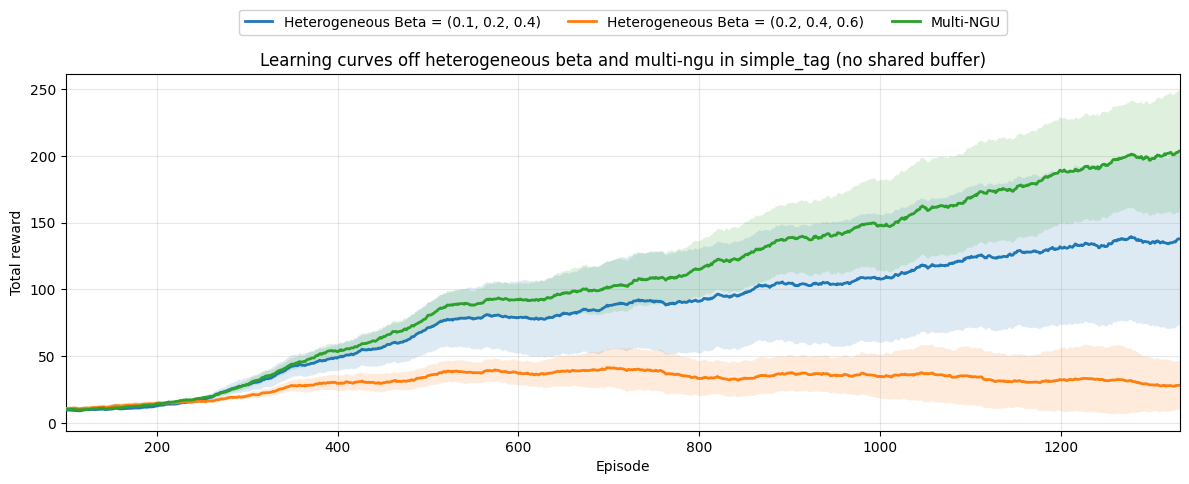

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

configs = {
    "Heterogeneous Beta = (0.1, 0.2, 0.4)": {"folder": "Appendix/heterogeneous_beta/betas_0.1_0.2_0.4", "n_runs": 15},
    "Heterogeneous Beta = (0.2, 0.4, 0.6)": {"folder": "Appendix/heterogeneous_beta/betas_otros", "n_runs": 10},
    "Multi-NGU": {"folder": "Appendix/heterogeneous_beta/multi_ngu", "n_runs": 15},
}

agent   = "adversary_0"
window  = 100

def rolling(x, w):
    return x.rolling(window=w, min_periods=w).mean()

plt.figure(figsize=(12,5))

for idx, (label, cfg) in enumerate(configs.items()):
    folder = cfg["folder"]
    n_runs = cfg["n_runs"]
    dfs = []
    for i in range(1, n_runs + 1):
        path = f"{folder}/run_{i}.csv"
        try:
            df = pd.read_csv(path, usecols=["episode", agent])
            dfs.append(df.rename(columns={agent: f"run_{i}"}))
        except:
            continue

    # Merge por episodio
    merged = dfs[0]
    for df in dfs[1:]:
        merged = merged.merge(df, on="episode", how="inner")

    run_cols = [c for c in merged.columns if c.startswith("run_")]

    # Suavizar cada run primero
    for c in run_cols:
        merged[c] = rolling(merged[c], window)

    # Media entre runs
    mean = merged[run_cols].mean(axis=1)

    # Banda según modo
    sem  = merged[run_cols].std(axis=1, ddof=1) / np.sqrt(len(run_cols))
    lo   = mean - 1.96 * sem
    hi   = mean + 1.96 * sem

    # Limitar a puntos válidos (tras el rolling)
    valid = ~mean.isna()
    x = merged.loc[valid, "episode"]
    y = mean.loc[valid]
    lo = lo.loc[valid]
    hi = hi.loc[valid]

    # Línea + banda (baja opacidad y zorder ordenado)
    plt.plot(x, y, label=label, linewidth=2, zorder=10+idx)
    plt.fill_between(x, lo, hi, alpha=0.15, linewidth=0, zorder=idx)

plt.xlim(x.min(), x.max())  # recorta márgenes del eje
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title(f"Learning curves off heterogeneous beta and multi-ngu in simple_tag (no shared buffer)")
plt.grid(True, alpha=0.3)
plt.legend(framealpha=0.9, loc="upper center", bbox_to_anchor=(0.5, 1.2), ncol=len(configs))
plt.tight_layout()
plt.show()
